<br><br>
<center><font size='5'><b>Deep Learning for All_pytorch</b></font><br><br><font size='5'>Weight initialization, Dropout, BN<b></b></font>

# Weight initialization

## RBM (Restricted Boltzmann Machine) / DBN

![image](https://user-images.githubusercontent.com/48466625/61194916-d01ddc80-a6ff-11e9-999f-70b47f743a89.png)

- Restricted의 의미 : 레이어 안에서 노드끼리의 연결이 없다

![image](https://user-images.githubusercontent.com/48466625/61194950-0a877980-a700-11e9-96d1-44732f333790.png)

- Pre-training 단계
  - 1) 두개 레이어끼리 RBM으로 x를 학습한다(forward와 backward로, x-h_1사이)
  - 2) 두개 레이어 위에 한개 레이어를 쌓아서(h2), x-h_1사이 파라미터는 고정, 윗 레이어에서만 RBM으로 학습
  - 3) 2) 단계를 반복적으로 진행하면서,
  - 4) 마지막 레이어까지 계속 반복해서 stacking
- Fine-tuning
  - RBM 학습된 것을 weight 초기화시킨 후에, 일반적으로 뉴럴 네트워크 학습 방식으로 전체를 다시 한번 학습

## Xavier / He initialization

- Normal distribution 방식으로 웨이트를 초기화하는 방식과,
- Uniform distribution 방식으로 웨이트를 초기화하는 방식이 있음

![image](https://user-images.githubusercontent.com/48466625/61195117-0c9e0800-a701-11e9-8286-24647c20ffb8.png)

In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    

# parameters
learning_rate = 0.001
training_epochs = 5
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# nn layers
linear1 = torch.nn.Linear(784, 256, bias=True)
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()

In [2]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)

Parameter containing:
tensor([[-0.0215, -0.0894,  0.0598,  ...,  0.0200,  0.0203,  0.1212],
        [ 0.0078,  0.1378,  0.0920,  ...,  0.0975,  0.1458, -0.0302],
        [ 0.1270, -0.1296,  0.1049,  ...,  0.0124,  0.1173, -0.0901],
        ...,
        [ 0.0661, -0.1025,  0.1437,  ...,  0.0784,  0.0977, -0.0396],
        [ 0.0430, -0.1274, -0.0134,  ..., -0.0582,  0.1201,  0.1479],
        [-0.1433,  0.0200, -0.0568,  ...,  0.0787,  0.0428, -0.0036]],
       requires_grad=True)

In [3]:
# model
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)


# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.249874651
Epoch: 0002 cost = 0.093767375
Epoch: 0003 cost = 0.060372889
Epoch: 0004 cost = 0.043052610
Epoch: 0005 cost = 0.032541521
Learning finished


In [4]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9787999987602234
Label:  8
Prediction:  8


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Dropout

![image](https://user-images.githubusercontent.com/48466625/61195313-255aed80-a702-11e9-9f05-b1d63e5a4f66.png)

- model.train() & model.eval()

In [5]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [7]:
# parameters
learning_rate = 0.001
training_epochs = 5
batch_size = 100
drop_prob = 0.3 # dropout 할 portion

In [8]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [9]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [10]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [29]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[ 0.0058, -0.0134,  0.0013,  ...,  0.0883, -0.0252,  0.1026],
        [-0.1026,  0.0916,  0.0785,  ...,  0.1064, -0.0113, -0.1035],
        [-0.0969, -0.0542, -0.0002,  ...,  0.0065,  0.1012, -0.0193],
        ...,
        [ 0.0156, -0.0990, -0.0204,  ...,  0.0632, -0.0228,  0.0767],
        [ 0.0333,  0.1068,  0.0974,  ..., -0.0172,  0.0435, -0.0725],
        [ 0.0062,  0.0018,  0.0653,  ...,  0.0934,  0.1015,  0.1043]],
       requires_grad=True)

In [30]:
# model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

In [31]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
total_batch = len(data_loader)
model.train()    # train 모드로 학습을 하겠다 (dropout=True)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.309967339
Epoch: 0002 cost = 0.142986417
Epoch: 0003 cost = 0.110701062
Epoch: 0004 cost = 0.094230086
Epoch: 0005 cost = 0.081334777
Learning finished


In [33]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # dropout이 False가 되어서, evaluation mode를 설정할 수 있게 됌.

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9775000214576721
Label:  8
Prediction:  8


# Batch normalization

## Gradient Vanishing / Exploding

Solution

- Activation function 바꾸기 (when it comes to vanishing problem)
- 초기화 잘해보기 (when it comes to vanishing problem)
- learning rate 작게 하기(when it comes to exploding problem)
- __Batch normalization__

## Internal Covariate Shift

![image](https://user-images.githubusercontent.com/48466625/61195825-a798e100-a705-11e9-8211-9f7acb7b3206.png)

- trainset과 testset의 분포가 차이가 있다 --> Covariate shift
- 인풋데이터가 레이어를 지나면서 분포가 계속 바뀐다. 한 레이어 레이어마다 covariate shift가 발생한다.
  - 원래는 입력데이터와 출력데이터의 차이를 완화시키기 위해 입력데이터를 노말라이즈해서 사용했는데,
  - 인풋과 아웃풋의 문제가 아니라, 한 레이어 레이어마다 covariate shift가 발생 한다(Internal)
  
![image](https://user-images.githubusercontent.com/48466625/61195886-0d856880-a706-11e9-89f2-c12b74a9d701.png)

- mini-batch들 마다 노말라이즈를 시켜주고, __Scale and shift__ (gamma와 beta는 학습해야할 파라미터)
- dropout과 마찬가지로 model.train() & model.eval() 모드를 각각 따로 한다.
- 학습 당시에 구하는 mu와 sigma는 sample mean, sample variance
  - 각각 따로 저장해서, 이 것들을 이용해 learning mean과 learning variance를 구한다
  - 이것들은 변하지 않는 고정된 값. -> 이 값들을 inference 시에 사용하여 노말라이즈 한다.

## BN

In [34]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [36]:
# parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 32

In [37]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [38]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [39]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [40]:
# model(bn한 모델과 안한 모델)
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [41]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [42]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.12380(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19853(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.12778(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19657(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10016(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.14756(nn_acc:0.96)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12334(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16910(nn_acc:0.95)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08795(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.13455(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11704(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16184(nn_acc:0.96)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07466(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.18925(nn_acc:0.95)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.10001(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.21801(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [43]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


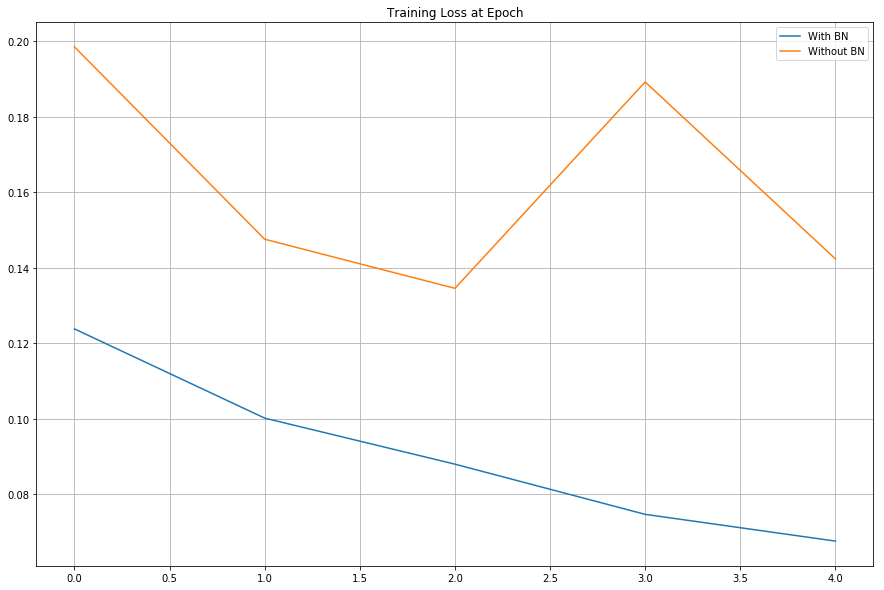

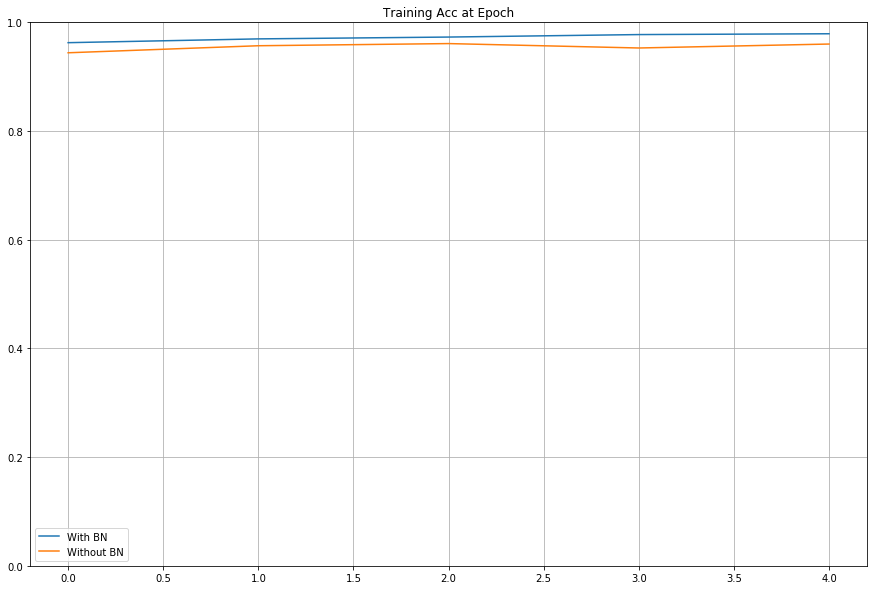

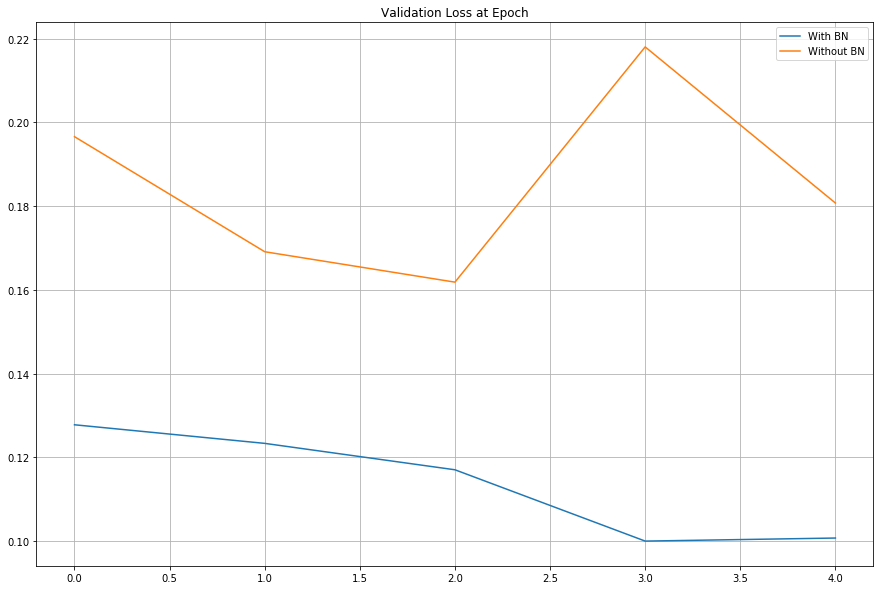

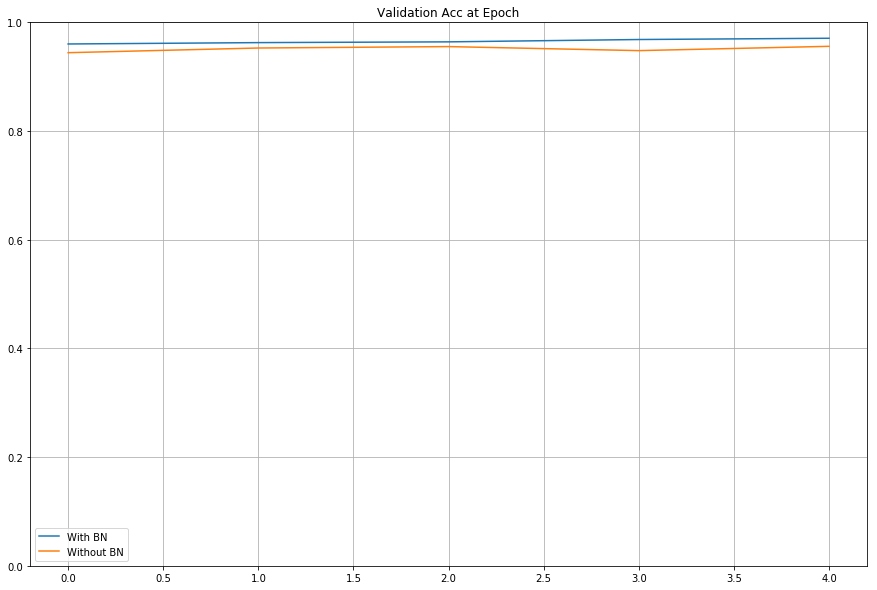

In [44]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')